In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth
import functions_velocity

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

import xarray as xr

In [2]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_pulse10'
gridT = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_T.nc')
gridU = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_U.nc')
gridV = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_V.nc')
gridW = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_W.nc')
sal = np.tile(gridT['vosaline'],(1,1))
tem = np.tile(gridT['votemper'],(1,1))
utau = np.tile(gridU['sozotaux'],(1,1))
vtau = np.tile(gridV['sometauy'],(1,1))
vE = gridW['veddyvisc']
depthw = gridW['depthw']
nav_lat = gridW['nav_lat']

In [3]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']
coord_nav_lat = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

# Eddy viscosity in domain at time and depth

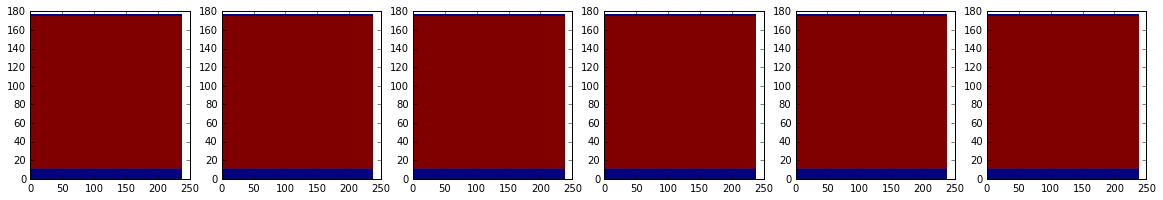

In [4]:
fig, ax = plt.subplots(1,6,figsize=(20,3), sharex=True)
for t, d, i in zip([200,203,206,200,203,206], [0,0,0,1,1,1], np.arange(6)):
    p = ax[i].pcolor(vE[t,d,:,:], vmin = 0, vmax=0.000105)

# Wind stress and eddy viscosity

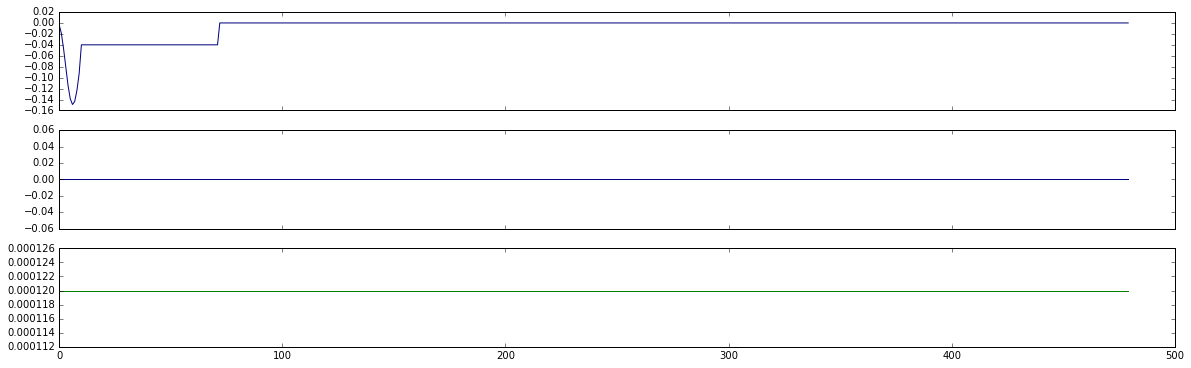

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,6), sharex=True)
ax1.plot(utau[:,100,100], c='navy')
ax2.plot(vtau[:,100,100], c='navy')
ax3.plot(vE[:,0,100,100], c='y')
ax3.plot(vE[:,2,100,100], c='r')
ax3.plot(vE[:,4,100,100], c='b')
ax3.plot(vE[:,7,100,100], c='g')

# Coriolis parameter

$$f(\lambda)= 2 \Omega \sin(\lambda)$$

$$\Omega = \frac{2 \pi}{24 hours}$$

The average latitude at the northern boundary is 70.943. The average coriolis parameter is 0.0001374. fpar was calculated at all points along the boundary.

In [6]:
indN = -2
latN = nav_lat[indN,:]
omega = (2 * np.pi) / (24 * 60 * 60)
f = 2 * omega * np.sin(np.deg2rad(latN))

In [7]:
f.shape, type(f)

((237,), xarray.core.dataarray.DataArray)

# Ekman layer thickness

$$\delta = \sqrt \frac{2\nu_E}{f}$$

In [8]:
indt = 0
vEN = vE[indt, :, -2, :]
fN = np.tile(f,(30,1))
delta = np.sqrt((2 * vEN) / fN)

In [13]:
vEN.shape, fN.shape, delta.shape

((30, 237), (30, 237), (30, 237))

# Ekman component

$$ fv = - \frac{1}{\rho} \frac{\partial \tau_x}{\partial z}$$

$$ fu = \frac{1}{\rho} \frac{\partial \tau_y}{\partial z}$$

Or:

$$ fv_E = - \nu_E \frac{\partial^2u}{\partial z^2}$$

$$ fu_E = \nu_E \frac{\partial^2v}{\partial z^2}$$

Gives:

$$u_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) - \tau_y sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

$$v_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) + \tau_y cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

In [12]:
deps = np.transpose(np.tile(-1 * depthw, (237, 1)))
lats = np.tile(latN, (30, 1))
p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [deps,lats], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

deps.shape, lats.shape, type(deps), type(lats)

((30, 237), (30, 237), numpy.ndarray, numpy.ndarray)

In [14]:
SA = sal[indt, :, indN, :]
CT = tem[indt, :, indN, :]
rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

SA.shape, rho.shape, type(SA), type(rho)

((30, 237), (30, 237), numpy.ndarray, numpy.ndarray)

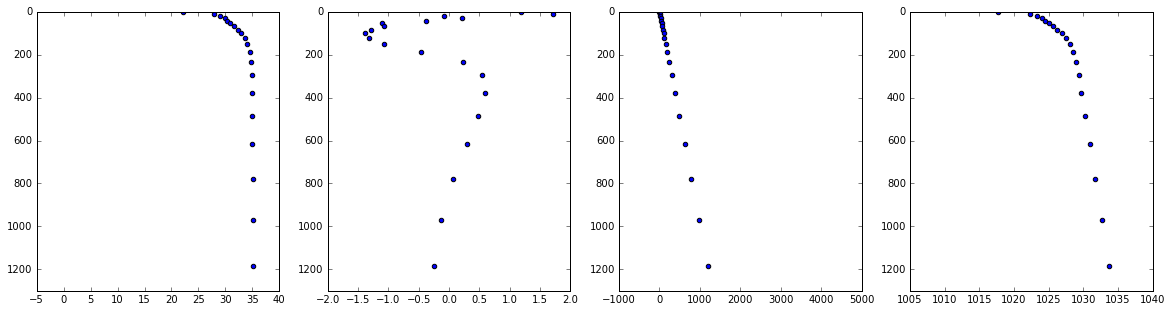

In [15]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
for var, i in zip([SA, CT, p, rho], np.arange(4)):
    ax[i].scatter(var[:,100], depthw)
    ax[i].set_ylim([1300, 0])

In [16]:
coeff = (np.sqrt(2)/(rho * fN * delta)) * np.exp(deps / delta)

brackets = (deps / delta) - (np.pi / 4)

tao_x = np.tile(utau[indt, indN, :],(30,1))
tao_y = np.tile(vtau[indt, indN, :],(30,1))

uE = coeff * ((tao_x * np.cos(brackets)) - (tao_y * np.sin(brackets)))
vE = coeff * ((tao_x * np.sin(brackets)) - (tao_y * np.cos(brackets)))

In [17]:
coeff.shape, brackets.shape, tao_x.shape, uE.shape

((30, 237), (30, 237), (30, 237), (30, 237))

# Pressure driven component

Ekman transport resulting from winds distorts the sea surface height. These distortions (hills and valleys) produce geostrophic currents which dominate the large scale circulation patterns in the upper ocean (Beaufort Gyre). Increased pressure caused by the piling up of surface water causes water to flow away.

$$ fv_g =  \frac{1}{\rho} \frac{\partial p}{\partial x} $$

$$ fu_g = - \frac{1}{\rho} \frac{\partial p}{\partial y} $$

Gives:

$$ v_g = \frac{1}{\rho f} \frac{\partial p}{\partial x} $$

$$ u_g = - \frac{1}{\rho f} \frac{\partial p}{\partial y} $$

And:
$$ p = \int_{-z}^{\eta} g \rho(z) dz = \int_{0}^{\eta} g \rho(z) dz + \int_{-z}^{0} g \rho(z) dz$$

So the geostrophic currents are:
$$u_g = - \frac{1}{\rho f}\frac{\partial}{\partial y} \int_{-z}^{0} g \rho(z) dz - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

$$v_g = \underbrace{\frac{1}{\rho f}\frac{\partial}{\partial x} \int_{-z}^{0} g \rho(z) dz}_\text{V baroclinic} + \underbrace{\frac{g}{f} \frac{\partial \eta}{\partial x}}_\text{V barotropic}$$

Where the surface currents are:
$$u_s = - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

$$v_s = \frac{g}{f} \frac{\partial \eta}{\partial x}$$



To use these equations, we need to know the surface height with respect to the level surface (geoid: the sea surface of an ocean at rest). Tides and currents are the two major factors that contribute to the dynamic topography of the ocean's surface. 

<span style="color:blueviolet">I don't have density or pressure data. Use density for pressure gradient, but I'm doing opposite.</span>

<span style="color:blueviolet">Sea surface height from altimetry data to calculate surface velocity? Arctic is poorly observed (poor missions coverage and ice) but found paper.</span>

Dynamic methods (for baroclinic component) (if we have pressure instead of depth):

$$u_{baroc} = \frac{1}{\rho f}\frac{\partial}{\partial y} \int_{-z}^{0} \rho(z) dz= - \frac{1}{\rho f}\frac{\partial}{\partial y} \int_{p}^{p_{ref}} \alpha(z) dp$$

Thermal wind: Still needs a constant, or reference velocity, equivalent to barotropic velocity.

$$ \frac{\partial u}{\partial z} = \frac{g}{\rho f} \frac{\partial \rho}{\partial y} $$

<span style="color:blueviolet">But if the surface velocity is mostly currents and tides, and I have small tides, can I just use the velocity from the wind stress (even though this is already in ekman component).</span>

References:
* http://www.rsmas.miami.edu/users/lbeal/MPO603/Lecture%2012.xhtml
* https://ocw.mit.edu/courses/mechanical-engineering/2-011-introduction-to-ocean-science-and-engineering-spring-2006/readings/geostrophic.pdf
* https://marine.rutgers.edu/dmcs/ms501/2004/Notes/Wilkin20041101.htm
* http://talleylab.ucsd.edu/ltalley/sio210/dynamics_rotation/lecture_dynamics_geostrophy.pdf
* http://onlinelibrary.wiley.com/doi/10.1002/2015JC011579/full